# Clustering

In [1]:
#import library
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from IPython.display import clear_output
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
sns.set()
np.random.seed(42)
%matplotlib inline

In [2]:
df = pd.read_csv('data/main_dataset.csv')
df.head()

,Unnamed: 0,sofifa_id,age,height_cm,weight_kg,overall,potential,value_eur,wage_eur,preferred_foot,...,mentality_composure,defending_marking,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,best_pos
0,0,158023,32,170,72,94,94,95500000,565000,Left,...,96,33,37,26,6,11,15,14,8,Fwd_Winger
1,1,20801,34,187,83,93,93,58500000,405000,Right,...,95,28,32,24,7,11,15,14,11,Fwd_Centre
2,2,190871,27,175,68,92,92,105500000,290000,Right,...,94,27,26,29,9,9,15,15,11,Fwd_Winger
3,3,200389,26,188,87,91,93,77500000,125000,Right,...,68,27,12,18,87,92,78,90,89,Goal_Keeper
4,4,183277,28,175,74,91,91,90000000,470000,Right,...,91,34,27,22,11,12,6,8,8,Fwd_Winger


In [3]:
feature = ['weak_foot', 'skill_moves', 'shooting', 'attacking_crossing',
        'attacking_finishing', 'attacking_volleys', 'skill_dribbling',
        'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
        'movement_agility', 'movement_balance', 'power_shot_power',
        'power_long_shots', 'mentality_positioning', 'mentality_vision',
        'mentality_penalties', 'goalkeeping_diving', 'goalkeeping_handling',
        'goalkeeping_kicking', 'goalkeeping_positioning',
        'goalkeeping_reflexes',
        'passing', 'dribbling', 'defending', 'physic'] #combine with my previous feature
data_selected = df[feature]
data_selected.head()

,weak_foot,skill_moves,shooting,attacking_crossing,attacking_finishing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,...,mentality_penalties,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,passing,dribbling,defending,physic
0,4,4,92.0,88,95,88,97,93,94,92,...,75,6,11,15,14,8,92.0,96.0,39.0,66.0
1,4,5,93.0,84,94,87,89,81,76,77,...,85,7,11,15,14,11,82.0,89.0,35.0,78.0
2,5,5,85.0,87,87,87,96,88,87,81,...,90,9,9,15,15,11,87.0,95.0,32.0,58.0
3,3,1,0.0,13,11,13,12,13,14,40,...,11,87,92,78,90,89,0.0,0.0,0.0,0.0
4,4,4,83.0,81,84,83,95,83,79,83,...,88,11,12,6,8,8,86.0,94.0,35.0,66.0


## Reduce dimension PCA
https://medium.com/@dmitriy.kavyazin/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2


In [4]:
pca = PCA(n_components=2)
# X_std = data_selected
X_std = MinMaxScaler().fit_transform(data_selected)
X_transform = pca.fit_transform(X_std)

In [5]:
X_transform

array([[-1.69915861, -0.90390091],
       [-1.55618871, -0.86337319],
       [-1.57225763, -0.94971777],
       ...,
       [ 0.41402413,  0.41701656],
       [ 0.40295936,  0.32712022],
       [ 0.35568779,  0.381389  ]])

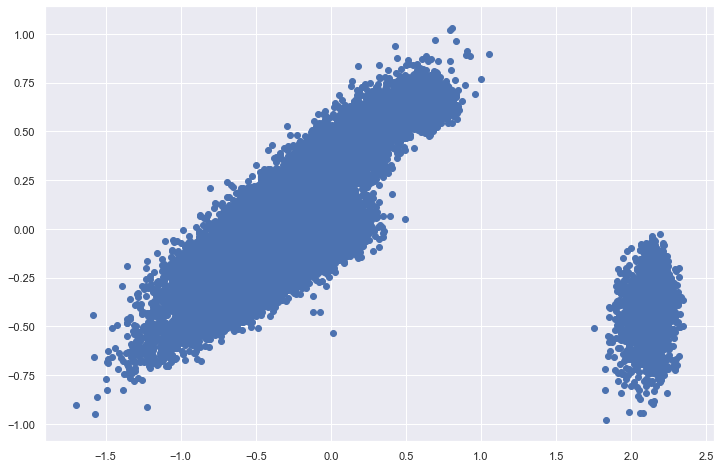

In [6]:
plt.figure(figsize=(12, 8))
plt.scatter(X_transform[:,0], X_transform[:,1])

In [7]:
# remove outliers
# quantile_95 = df['weight_kg'].quantile(0.999)
# df_95 = df[df['weight_kg'] < quantile_95]

In [8]:
# plt.figure(figsize=(10, 10))
# sns.scatterplot(df_95['goalkeeping_positioning'],df_95['goalkeeping_reflexes'])

### Define functions

In [9]:
def euclidean_distance(a, b): #calculate euclidean distance
    return np.sqrt(np.sum((a - b)**2))
def is_convergen(old, new, K): #check is new clusters convergen or not, if convergen it will stop the loop
    distances = [euclidean_distance(old[i], new[i]) for i in range(K)]
    return sum(distances) == 0
def select_centroid(data, centroids):
    distances = [euclidean_distance(data, point) for point in centroids]
#     print(distances,data)
    return np.argmin(distances)
def get_centroids(clusters, K, n_features, X):
    # assign mean value of clusters to centroids
    centroids = np.zeros((K, n_features))
    for cluster_idx, cluster in enumerate(clusters):
        cluster_mean = np.mean(X[cluster], axis=0)
        centroids[cluster_idx] = cluster_mean
    return centroids

In [28]:
def kMeans(X, K = 2, max_iter = 100, verbose = True):
    X = np.array(X)
    n_data, n_feature = X.shape
    y = np.full(n_data, -1)
    cancel_token = True
    i = 0
    rand_c = np.random.choice(n_data, K, replace=False)
    centroids = [np.array(X[idx]) for idx in rand_c]
    
    while(i < max_iter and cancel_token):
        for idx, row in enumerate(X):
            y[idx] = select_centroid(row, centroids)
        old_centroids = centroids #save old centroids
        #update new centroids
        temp = np.zeros((K, n_feature))
        for cluster in range(K) : #for each member of cluster, get mean value
            idx = np.where( y == cluster)
            temp[cluster] = np.mean(X[idx],axis = 0)
        centroids = temp #UPDATE!
        if is_convergen(old_centroids, centroids, K):
            cancel_token = False
        i+=1
        if verbose:
            print('iteration = ' ,i)
            clear_output(wait=True)
    return y, centroids
def plot_cluster(X, label, center):
    plt.figure(figsize=(12, 8))
    plt.scatter(X[:, 0], X[:, 1], c=label, s=50, cmap='viridis')
    plt.scatter(center[:, 0], center[:, 1], marker="x", c='black');
    plt.show()

### Main Program

Define parameters

In [30]:
K = 5
max_iter = 10

In [31]:
y_pred, center = kMeans(X_transform, K, max_iter)

iteration =  10


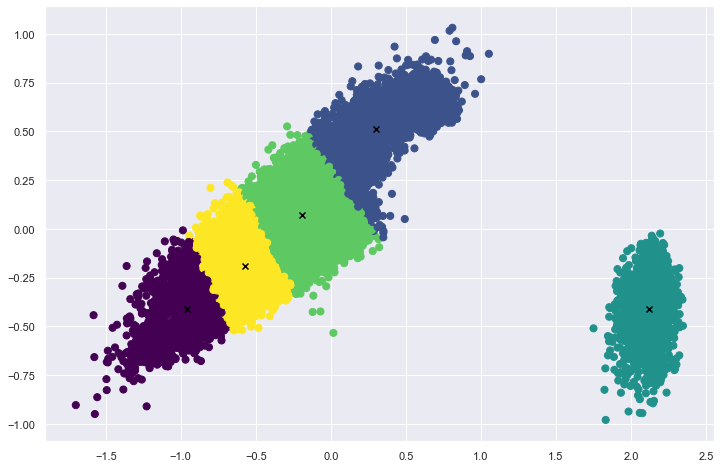

In [32]:
plot_cluster(X_transform,y_pred,center)

## Evaluate Score

Using silhouette coefficient

![Function](sihouette.jpg)

https://medium.com/@ODSC/assessment-metrics-for-clustering-algorithms-4a902e00d92d

In [19]:
from sklearn.metrics import silhouette_samples, silhouette_score

In [22]:
result = silhouette_samples(X_transform,y_pred)
result

array([0.55132816, 0.57137483, 0.55741392, ..., 0.56037573, 0.56964427,
       0.59575934])

In [23]:
np.mean(result)

0.7499937439212352

In [26]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=5, random_state=0).fit(X_transform)
pred = kmeans.predict(X_transform)

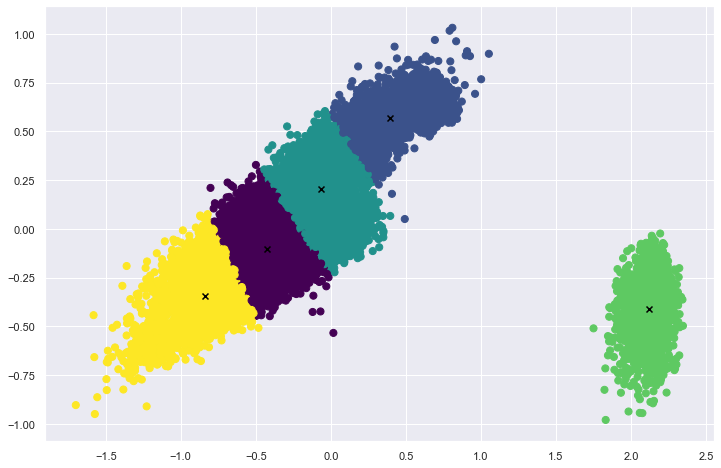

In [29]:
plot_cluster(X_transform,pred,kmeans.cluster_centers_)